In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import collections
import functools
import abc
import random

import numpy as np
import jax
import jax.numpy as jnp
import jax.experimental.optimizers
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sobol_seq
import dict_minimize

import bvbq
# import bvbq.gp
# import bvbq.bvi
# import bvbq.distributions

In [3]:
ndim = 2
def exponential_quartic(x):
    x1,x2 = x[...,0],x[...,1]
    res = -0.1*x1**4 -0.5*(2*x2-x1**2)**2
#     return -0.5*((x1+1)**2 + (x2 - 1)**2)
    return res

W0806 14:07:53.108938 139662470604608 xla_bridge.py:137] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


-0.0
--
{'mean', 'raw_lengthscale', 'raw_theta', 'raw_noise'}
[]
{'mean', 'noise'}
0.0
--
If tensor has more than 2 dimensions, only diagonal of covariance is returned


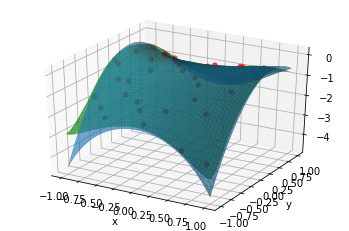

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
x = np.linspace(-1,1)
y = np.linspace(-1,1)
X,Y = np.meshgrid(x,y)
Z = exponential_quartic(np.stack([X,Y],axis=-1))
ax.plot_surface(X,Y,Z,alpha=0.7)

xys = (2*(sobol_seq.i4_sobol_generate(2,40)-0.5)) #[-1,1] cube
zs = exponential_quartic(xys)
ax.scatter(xys[:,0],xys[:,1],zs,color='red')
ax.set_xlabel('x');
ax.set_ylabel('y');

logprobgp = bvbq.gp.SimpleGP(2,kind='smatern32',noise=0,zeromax=True)
logprobgp.mean = -10
logprobgp.fix_mean()
logprobgp.fix_noise()
logprobgp.set_data(xys,zs,empirical_params=True)
logprobgp.optimize_params()
Zreg = logprobgp.predict(np.stack([X,Y],axis=-1))[0]
ax.plot_surface(X,Y,Zreg,alpha=0.7,color='green')

In [5]:
x = np.random.rand(5,2)

distrib = bvbq.distributions.DiagonalNormalDistribution(-jnp.ones(2),0.1*jnp.ones(2))
print(distrib.sample(100).mean(axis=0))
print(distrib.logprob(x))
print(distrib.sample(101).mean(axis=0))
mixdistrib = distrib.make_mixture()
mixdistrib.add_component(jnp.ones(2),0.1*jnp.ones(2),0.1)
mixdistrib.add_component(2*jnp.ones(2),0.1*jnp.ones(2),0.1)
print(mixdistrib.logprob(x))
print(mixdistrib.sample(100).mean())
print(mixdistrib.sample(101).mean())

[-1.0171045  -0.98187375]
[-26.67308  -23.065819 -27.07777  -27.522572 -25.358944]
[-0.95875174 -0.9712621 ]
[-4.614374  -4.1364164 -3.1656404 -3.3994203 -4.9447317]
-0.53167546
-0.52552104


In [8]:
key1 = jax.random.PRNGKey(250)
key2,_ = jax.random.split(key1)
mixmeans_test = 4*jax.random.normal(key1,shape=(12,1))
# mixmeans_test = jnp.ones((12,1))
mixvars_test = jnp.ones((12,1))
mixweights_test = jnp.ones(12)/12
# mixmeans_test = jnp.array([[3.0],[-3.0]])
# mixvars_test = jnp.ones((2,1))
# mixweights_test = jnp.ones(2)/2
# bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
#                     samples,mixmeans,mixvars,mixweights)

In [14]:
def logprob_mixgaussians(x):
    return bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                        x,mixmeans_test,mixvars_test,mixweights_test).reshape(-1,1)
def logprob_t(x,nu):
    normalizer = jax.scipy.special.gammaln((nu+1)/2) \
                 -jax.scipy.special.gammaln(nu/2) \
                 -0.5*jnp.log(jnp.pi*nu)
    main_term = -(nu+1)/2*jnp.log(1+x**2/nu)
    return main_term + normalizer

xdata = jnp.linspace(-10,10).reshape(-1,1)
# ydata = logprob_t(xdata,2.5)
ydata = logprob_mixgaussians(xdata)
logprobgp = bvbq.gp.SimpleGP(1,kind='smatern52',noise=0,zeromax=True)
logprobgp.mean = -10.0
logprobgp.fix_mean()
logprobgp.fix_noise()
logprobgp.set_data(xdata,ydata,empirical_params=False)
# logprobgp.optimize_params()

-1.9357822
--


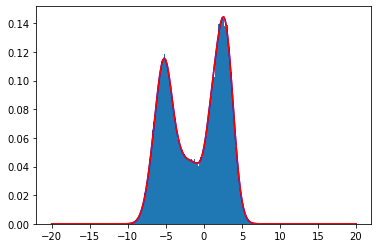

In [15]:
xplot = np.linspace(-20,20,201).reshape(-1,1)
yplot1 = logprob_mixgaussians(xplot)
# yplot1 = logprob_t(xplot,2.5)
yplot2 = logprobgp.predict(xplot,return_cov=False)
plt.plot(xplot,jnp.exp(yplot1),'b')
plt.plot(xplot,jnp.exp(yplot2),'r')
samples1 = bvbq.distributions.MixtureDiagonalNormalDistribution.sample_(100000,
                                                             mixmeans_test,
                                                             mixvars_test,
                                                             mixweights_test,
                                                             key1,key2)
plt.hist(samples1.flatten(),density=True,bins=100);

In [16]:
samples1[jnp.abs(samples1) < 3.0]

DeviceArray([ 1.7784029 , -2.1399064 ,  1.9162501 , ...,  2.0061975 ,
              0.79056287, -1.923612  ], dtype=float32)

In [17]:
def mcbq_dmvn_elbo(logprobgp,mean,var,nsamples):
    term1 = 0.5*jnp.sum(jnp.log(2*jnp.pi*jnp.e*var))
    term2 = bvbq.bq.separable_dmvn_bq(logprobgp,mean,var,return_var=False)
    return term1 + term2
#     term1 = distrib.monte_carlo_entropy(nsamples)
#     term2 = bq.monte_carlo_bayesian_quadrature(logprobgp,distrib,nsamples)
#     return term1 + term2

def objective_function_elbo(params):
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
    res = -mcbq_dmvn_elbo(logprobgp,mean,var,1000)
    return res

In [18]:
params = {'mean':jnp.zeros(1)-1.0,'rawvar':jnp.zeros(1)}
jax.value_and_grad(objective_function_elbo)(params)
maxiter = 100
alpha = 1e-1
optwrapper = bvbq.optwrapper.JaxOptWrapper("adam",alpha)
func_and_grad_elbo = jax.value_and_grad(objective_function_elbo)
optwrapper.init(params,func_and_grad_elbo)
for k in range(maxiter):
    value,grads = optwrapper.step()
    params = optwrapper.params
#     print(value,params['mean'],jax.nn.softplus(params['rawvar']))
mean,rawvar = params['mean'],params['rawvar']
var = jax.nn.softplus(rawvar)
distrib = bvbq.distributions.DiagonalNormalDistribution(mean,var)

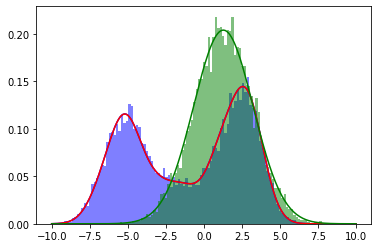

In [19]:
xplot = np.linspace(-10,10,201).reshape(-1,1)
# yplot1 = logprob_t(xplot,2.5)
yplot1 = logprob_mixgaussians(xplot)
yplot2 = logprobgp.predict(xplot,return_cov=False)
yplot3 = distrib.logprob(xplot).reshape(-1,1)
plt.plot(xplot,jnp.exp(yplot1),'b')
plt.plot(xplot,jnp.exp(yplot2),'r')
plt.plot(xplot,jnp.exp(yplot3),'g')
samples1 = bvbq.distributions.MixtureDiagonalNormalDistribution.sample_(10000,
                                                             mixmeans_test,
                                                             mixvars_test,
                                                             mixweights_test,
                                                             key1,key2)
samples3 = distrib.sample(10000)
plt.hist(samples1.flatten(),density=True,bins=100,alpha=0.5,color='blue');
plt.hist(samples3.flatten(),density=True,bins=100,alpha=0.5,color='green');

In [20]:
def mcbq_dmvn_relbo(logprobgp,mean,var,mixmeans,mixvars,mixweights,
                    key,nsamples=1000,logdelta=-10,reg=1e-2):
    subkey,key = jax.random.split(key)
    samples = bvbq.distributions.DiagonalNormalDistribution.sample_(nsamples,mean,var,subkey)
    term1 = bvbq.bq.separable_dmvn_bq(logprobgp,mean,var,return_var=False) #Variance
#     print(mixmeans,mixvars,mixweights)
    term2 = bvbq.utils.lb_mvn_mixmvn_cross_entropy(mean,var,mixmeans,mixvars,mixweights,logdelta)
#     term2 = -bvbq.utils.logbound(
#                 bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
#                     samples,mixmeans,mixvars,mixweights),
#                 logdelta).mean()
#     term2 = -bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
#                     samples,mixmeans,mixvars,mixweights).mean()
    term3 = 0.5*jnp.sum(jnp.log(2*jnp.pi*jnp.e*var)) #Entropy
    return term1 + term2 + reg*term3

def mcbq_mixdmvn_gradboost_elbo(logprobgp,weight,mean,var,
                                mixmeans,mixvars,mixweights,
                                key,nsamples=1000):
    mixmeans_up = jnp.vstack([mixmeans,mean])
    mixvars_up = jnp.vstack([mixvars,var])
    mixweights_up = jnp.append((1-weight)*mixweights,weight)
    term1 = bvbq.bq.separable_mixdmvn_bq(logprobgp,mixmeans_up,
                                         mixvars_up,mixweights_up,
                                         return_var=False)
    subkeya,key = jax.random.split(key)
    subkeyb,key = jax.random.split(key)
    subkeyc,key = jax.random.split(key)
    samples2 = bvbq.distributions.MixtureDiagonalNormalDistribution.sample_(nsamples,
                                                                            mixmeans,
                                                                            mixvars,
                                                                            mixweights,
                                                                            subkeya,subkeyb)
    samples3 = bvbq.distributions.DiagonalNormalDistribution.sample_(nsamples,mean,var,subkeyc)
    term2 = -(1-weight)*bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                    samples2,mixmeans_up,mixvars_up,mixweights_up).mean()
    term3 = -weight*bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                    samples3,mixmeans_up,mixvars_up,mixweights_up).mean()
    return term1 + term2 + term3
#     term2 = weight*bvbq.bq.separable_dmvn_bq(logprobgp,mean,var,return_var=False)
#     subkey1,key = jax.random.split(key)
#     subkey2,key = jax.random.split(key)
#     samples3 = bvbq.distributions.MixtureDiagonalNormalDistribution.sample_(nsamples,
#                                                                             mixmeans,
#                                                                             mixvars,
#                                                                             mixweights,
#                                                                             subkey1,subkey2)
#     subkey3,key = jax.random.split(key)
#     samples4 = bvbq.distributions.DiagonalNormalDistribution.sample_(nsamples,mean,var,subkey)
#     mixmeans_up = jnp.vstack([mixmeans,mean])
#     mixvars_up = jnp.vstack([mixvars,var])
#     mixweights_up = jnp.append((1-weight)*mixweights,weight)
#     term3 = -(1-weight)*bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
#                     samples3,mixmeans_up,mixvars_up,mixweights_up).mean()
#     term4 = -weight*bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
#                     samples4,mixmeans_up,mixvars_up,mixweights_up).mean()
# #     term3 = -(1-weight)*join_distributions(samples3,weight,mean,var,mixmeans,mixvars,mixweights).mean()
# #     term4 = -weight*join_distributions(samples4,weight,mean,var,mixmeans,mixvars,mixweights).mean()
#     return term1 + term2 + term3 + term4

def join_distributions(samples,weight,mean,var,mixmeans,mixvars,mixweights):
    terma = bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                    samples,mixmeans,mixvars,mixweights)
    termb = bvbq.distributions.DiagonalNormalDistribution.logprob_(
                    samples,mean,var)
    term = bvbq.utils.logsumexp(jnp.stack([terma,termb],axis=-1),
                                weights=jnp.array([1.-weight,weight]),
                                axis=-1)
    return term

def objective_function_relbo(params,mixmeans,mixvars,mixweights,key):
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
    res = -mcbq_dmvn_relbo(logprobgp,mean,var,mixmeans,mixvars,mixweights,key,
                           nsamples=1000,logdelta=-10,reg=1e0)
    return res

def objective_function_gradboost(weight,mean,var,
                                 mixmeans,mixvars,mixweights,
                                 key):
    res = -mcbq_mixdmvn_gradboost_elbo(logprobgp,weight,mean,var,
                                mixmeans,mixvars,mixweights,
                                key,nsamples=1000)
    return res

In [21]:
key = jax.random.PRNGKey(100)
subkey,key = jax.random.split(key)
mixmeans,mixvars,mixweights = mixdistrib.params
mean = jnp.zeros(2)
rawvar = jnp.zeros(2)
var = jax.nn.softplus(rawvar)
params = {'mean':mean,'rawvar':rawvar}
func_and_grad_relbo = jax.value_and_grad(objective_function_relbo,argnums=0)
func_and_grad_gradboost = jax.value_and_grad(objective_function_gradboost,argnums=0)
weight = 0.2
print(func_and_grad_relbo(params,mixmeans,mixvars,mixweights,key))
print(func_and_grad_gradboost(weight,mean,var,mixmeans,mixvars,mixweights,key))
# bvbq.distributions.DiagonalNormalDistribution.logprob_(jnp.linspace(-5,5).reshape(-1,1),mean,var)

(DeviceArray(3.9180942, dtype=float32), {'mean': DeviceArray([-1.39953, -1.39953], dtype=float32), 'rawvar': DeviceArray([1.2001001, 1.2001001], dtype=float32)})
(DeviceArray(4.0916452, dtype=float32), DeviceArray(-1.4873686, dtype=float32))


In [22]:
distrib.params

(DeviceArray([1.2796971], dtype=float32),
 DeviceArray([3.825233], dtype=float32))

In [23]:
# mean,var = distrib.params
# mixmeans = mean.reshape(1,-1)
# mixvars = var.reshape(1,-1)
mean = jnp.zeros(1)
rawvar = jnp.zeros(1)
var = jax.nn.softplus(rawvar)
mixmeans = mean.reshape(1,-1)
mixvars = var.reshape(1,-1)*10
mixweights = jnp.ones(1)

alpha_boost = 1e-1
maxiter_boost = 100
maxiter = 3
# optwrapper = bvbq.optwrapper.JaxOptWrapper("sgd",alpha_relbo)

key = jax.random.PRNGKey(100)

for k in range(maxiter):
    params = {'mean':jnp.array(np.random.normal(size=(1,))),
              'rawvar':jnp.array(np.random.normal(size=(1,)))}
    params = collections.OrderedDict(params)
    res = dict_minimize.jax_api.minimize(func_and_grad_relbo, params,
                                         args=(mixmeans,mixvars,mixweights,subkey),
                                         method='CG',
                                         tol=1e-6)
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
#     mean = jnp.ones((1,));var=jnp.ones((1,))
    weight = 1e-4
    print('--')
    print(mean,var)
    for i in range(maxiter_boost):
        subkey,key = jax.random.split(key)
        res,gradweight = func_and_grad_gradboost(weight,mean,var,mixmeans,mixvars,mixweights,key)
#         weight = -alpha_boost*(i/10+1)**(-0.55)*gradweight
        weight -= alpha_boost*gradweight
        weight = jnp.clip(weight,1e-4,1-1e-4)
        if abs(gradweight) < 1e-4:
            break
        print(weight,res,gradweight)
#     mixdistrib.add_component(mean,var,weight)
    mixweights = jnp.append((1-weight)*mixweights,weight)
    mixmeans = jnp.vstack([mixmeans,mean])
    mixvars = jnp.vstack([mixvars,var])
    print(k,mean,var,weight)
    print('--')
    

--
[0.344508] [0.92017156]
1e-04 0.41732326 0.31406307
1e-04 0.4180967 0.2840495
1e-04 0.42411962 0.25574398
1e-04 0.40863067 0.33741236
1e-04 0.416319 0.32611036
1e-04 0.42527726 0.32568312
1e-04 0.3862072 0.34102297
1e-04 0.41369194 0.28963614
1e-04 0.45347673 0.3790841
1e-04 0.4292413 0.35047102
1e-04 0.37893713 0.39643478
1e-04 0.42804897 0.31481552
1e-04 0.42008394 0.2970662
1e-04 0.44127622 0.33784437
1e-04 0.42799112 0.27535534
1e-04 0.42182982 0.350276
1e-04 0.38181883 0.3184929
1e-04 0.41360024 0.31220436
1e-04 0.39895943 0.33451748
1e-04 0.39670694 0.28121424
1e-04 0.38746232 0.31091595
1e-04 0.41891348 0.298604
1e-04 0.39807805 0.36750317
1e-04 0.3895527 0.3314557
1e-04 0.40327436 0.3587613
1e-04 0.3987327 0.3435583
1e-04 0.46861312 0.2992196
1e-04 0.4303176 0.34148026
1e-04 0.41182908 0.28126764
1e-04 0.42443883 0.3465352
1e-04 0.42578772 0.3580823
1e-04 0.42437434 0.3059063
1e-04 0.3851766 0.32332897
1e-04 0.40517953 0.30081463
1e-04 0.37399003 0.3531518
1e-04 0.43375057 0

KeyboardInterrupt: 

In [ ]:
boostdistrib = bvbq.distributions.MixtureDiagonalNormalDistribution(mixmeans,mixvars,mixweights)
xplot = np.linspace(-10,10,201).reshape(-1,1)
yplot1 = logprob_mixgaussians(xplot)
yplot2 = logprobgp.predict(xplot,return_cov=False)
yplot3 = boostdistrib.logprob(xplot).reshape(-1,1)
plt.plot(xplot,jnp.exp(yplot1),'b')
plt.plot(xplot,jnp.exp(yplot2),'r')
plt.plot(xplot,jnp.exp(yplot3),'g')

In [416]:
mixweights

DeviceArray([4.7745638e-02, 9.5215434e-01, 9.9999997e-05], dtype=float32)